# Collaborative Topic Modeling in Python
*by Mario Damiano Russo*


In this notebook, we will implement **Collaborative Topic Modeling** as introduced in the 2011 paper by Wang and Blei “Collaborative topic modeling for recommending scientific articles”.

We will use the model to build a scalable recommender system for steam Games, using two open-source, freely accessible datasets:
- Steam 200k, containing information about per-game playtime for over 200k user-game interactions: https://www.kaggle.com/tamber/steam-video-games/version/1.
- Steam games complete dataset, containing various information for over 40k different Steam games, including title and description: https://www.kaggle.com/trolukovich/steam-games-complete-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
games = pd.read_csv("steam_games.csv")

# keep only the columns of interest
games = games.loc[:, ["name", "game_description"]]

# Drop NaN game descriptions and names
games = games[~games.game_description.isna()]
games = games[~games.name.isna()]

# Drop the introductory " About This Game " text
games.game_description = games.game_description.apply(lambda x: x.replace(" About This Game ", ""))
games = games[games.game_description != " "]

games.head(5)

,name,game_description
0,DOOM,"Developed by id software, the studio that pion..."
1,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roy...
2,BATTLETECH,From original BATTLETECH/MechWarrior creator ...
3,DayZ,The post-soviet country of Chernarus is struck...
6,Devil May Cry 5,The Devil you know returns in this brand new e...


In [3]:
ratings = pd.read_csv("steam-200k.csv", header = None)

# drop last empty column
ratings.drop(4, axis = 1, inplace=True)

# rename columns
ratings.columns = ["UserID", "Title", "Action", "Value"]

# keep only "play" variables
ratings = ratings[ratings.Action != "purchase"]
# and drop the "Action" column, as now it is all "play"s
ratings.drop("Action", axis = 1, inplace = True)

# to avoid multiplication overflow later on, constrain PlayTime 
# to be between 0 and 1
pt = ratings.Value
max_hours = pt.max()
min_hours = pt.min()
pt_scaled = (pt - min_hours) / (max_hours - min_hours)
ratings.Value = pt_scaled

ratings.head(3)

,UserID,Title,Value
1,151603712,The Elder Scrolls V Skyrim,0.023218
3,151603712,Fallout 4,0.007393
5,151603712,Spore,0.001259


In [4]:
# lowercase and apply special character removal to increase compatibility between titles
def lower_removedots(s):
    chars = ['!', ',', '.', '-', "'", '?', ":", "  "]
    for char in chars:
        s = s.replace(char, "")
    return s.lower()

games.name = games.name.apply(lambda x: lower_removedots(x))
ratings.Title = ratings.Title.apply(lambda x: lower_removedots(x))


titles_game = set(games.name.to_list())
titles_ratings = set(ratings.Title.to_list())

# save the list of titles for which we have both rating and description
intersection = titles_game.intersection(titles_ratings)

print(f"""Found {len(intersection)} titles for which we have both rating and description. 
Started with {len(titles_game)} in the games dataset and {len(titles_ratings)} in the ratings dataset.""")

Found 1991 titles for which we have both rating and description. 
Started with 37805 in the games dataset and 3600 in the ratings dataset.


In [5]:
# we now restrict both datasets based on our intersection
games = games[games.name.isin(intersection)]

# some games are duplicates / have the same name but different developer. Since its a few, we drop them altogether.
print(f"Found {games[games.name.duplicated()].shape[0]} duplicate entries in the games dataset.")
intersection = intersection.difference(set(games[games.name.duplicated()].name.to_list()))
games = games[games.name.isin(intersection)]
print(f"Found {games[games.name.duplicated()].shape[0]} duplicate entries in the games dataset.")


# the ratings dataset does not have duplicate item problems, so we just drop the titles we dropped in the games dataset.
ratings = ratings[ratings.Title.isin(intersection)]

# check to see that both datasets contain the same games.
try:
    assert len(set(ratings.Title.to_list())) == games.shape[0]
    print("Dataset game entries match.")
except AssertionError:
    raise Exception("Dataset game entries differ.")

Found 9 duplicate entries in the games dataset.
Found 0 duplicate entries in the games dataset.
Dataset game entries match.


# Creating the Ratings Matrix

In [6]:
R = pd.pivot_table(data=ratings, values = ["Value"], index=["UserID"], columns=["Title"])

# remove the level on top of game names called "Value"
R.columns = R.columns.droplevel()

# remove leftover columns name from pivot operation
R.columns.name = ""

# lastly, fill in the NaNs with 0's
R.fillna(0, inplace=True)

R.head(3)

,1 2 3 kick it (drop that beat like an ugly baby),10 second ninja,100% orange juice,10000000,12 labours of hercules ii the cretan bull,12 labours of hercules iii girl power,140,16bit trader,18 wheels of steel american long haul,3 stars of destiny,...,ziggurat,zombi,zombie army trilogy,zombie grinder,zombie panic source,zombie shooter 2,zombie zoeds,zoombinis,zuma deluxe,zumas revenge
UserID,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# define a game to hold out from the ratings matrix - we will do out-of-matrix prediciton on it

# we arbitrarily decide to drop the 1105th game
heldout_idx = 1105
heldout_name = R.columns[heldout_idx]
heldout_ratings = R[heldout_name]

R.drop(heldout_name, axis=1, inplace=True)

print(f"dropped '{heldout_name}' from the ratings matrix")

dropped 'need for speed undercover' from the ratings matrix


In [8]:
# assert that the pivot creation was successful
assert R.loc[151603712, "fallout 4"] == ratings[(ratings.UserID == 151603712) & (ratings.Title == "fallout 4")].Value.values[0]

print(f"Ratings matrix ready with {R.shape[0]} users and {R.shape[1]} games.")

r = R.values
sparsity = float(len(r.nonzero()[0]))
sparsity /= (r.shape[0] * r.shape[1])
sparsity *= 100
print(f"Matrix sparsity: {round(sparsity, 2)}%")

Ratings matrix ready with 10058 users and 1981 games.
Matrix sparsity: 0.23%


# Vanilla Matrix Factorization
We set a benchmark against which to compare CTM by implementing traditional Probabilistic Matrix Factorization.

In [9]:
# train - test split

def train_test_split(ratings, percs = [0.8, 0.2]):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        val_ratings = np.random.choice(ratings[user,:].nonzero()[0],
                                        size = round(len(ratings[user,:].nonzero()[0]) * percs[1]),
                                        replace=False
                                        )
        train[user, val_ratings] = 0
        validation[user, val_ratings] = ratings[user, val_ratings]
    
    return train, validation


train, val = train_test_split(r)
print(f"""Train-test split exectuted.
      Train: {round(len(train.flatten().nonzero()[0]) / len(r.flatten().nonzero()[0]) * 100, 2)}% 
      Test: {round(len(val.flatten().nonzero()[0]) / len(r.flatten().nonzero()[0]) * 100, 2)}% """)

Train-test split exectuted.
      Train: 83.22% 
      Test: 16.78% 


In [10]:
from sklearn.metrics import mean_squared_error

def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)

In [11]:
from tqdm import trange
import sys

class Recommender():
    def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.01, learning_rate=0.001):
        self.n_epochs = n_epochs
        self.n_latent_features = n_latent_features
        self.lmbda = lmbda
        self.learning_rate = learning_rate
    
    def predictions(self, P, Q):
        """
        returns dot product between:
            P = vector of preferences for user u / matrix of preferences
            Q = vector of qualities for item i / matrix of qualities
        """
        return np.dot(P.T, Q)
    
    def fit(self, X_train, X_val):
        # U = #users, I = #items
        U, I = X_train.shape
        
        # random initialization
        # get n_latent_features preference vectors of length U
        # get n_latent_features qualities vectors of length I
        # multiply both by 5 but any integer can go.
        self.P = 5 * np.random.rand(self.n_latent_features, U)
        self.Q = 5 * np.random.rand(self.n_latent_features, I)
        
        self.train_error = []
        self.val_error = []
        
        # store the indices combinations (u, i) that are nonzero
        users, items = X_train.nonzero()
        
        for iteration in trange(self.n_epochs, file=sys.stdout, desc='MF'):
            for u, i in zip(users, items):
                # compute the prediction error for the given cell (u, i)
                error = X_train[u, i] - self.predictions(self.P[:, u], self.Q[:, i])
                # update the vector of preferences for user u by considering the prediction error in (u, i)
                self.P[:, u] += self.learning_rate * (self.Q[:, i] * error - self.lmbda * self.P[:, u])
                # update the vector of preferences for item i by considering the prediction error in (u, i)
                self.Q[:, i] += self.learning_rate * (self.P[:, u] * error - self.lmbda * self.Q[:, i])
            self.train_error.append(mse(self.predictions(self.P, self.Q), X_train))
            self.val_error.append(mse(self.predictions(self.P, self.Q), X_val))
        
        return self
    
    def predict(self, X_train, user_index):
        # obtain the matrix of predicted ratings for all users and all items
        y_hat = self.predictions(self.P, self.Q)
        # then return the INDICES of the items for which there was no prediction for user u in the TRAINING SET
        predictions_index = np.where(X_train[user_index, :] == 0)[0]
        # return the predictions of the ratings that user u would give to the unrated elements.
        return y_hat[user_index, predictions_index].flatten()

In [12]:
recommender = Recommender(n_epochs=200, n_latent_features=3, lmbda=0.8).fit(train, val)

print(f"""Training done. 
        Train error: {recommender.train_error[-1]}
        Validation error: {recommender.val_error[-1]}""")

MF: 100%|██████████| 200/200 [05:05<00:00,  1.53s/it]
Training done. 
        Train error: 0.0017103170684324323
        Validation error: 0.4052483500636327


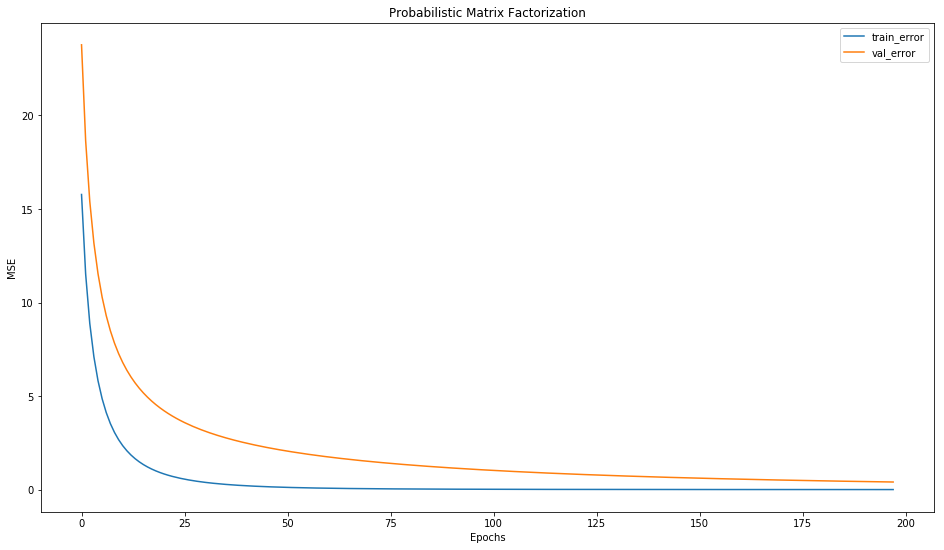

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(recommender.train_error[2:], label = "train_error")
ax.plot(recommender.val_error[2:], label = "val_error")
ax.set_title("Probabilistic Matrix Factorization")
ax.set_ylabel("MSE")
ax.set_xlabel("Epochs")
ax.legend();

# Topic Modeling with LDA

In [14]:
import spacy
from nltk.corpus import stopwords

from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary

import multiprocessing

Since lemmatization can take some time, the preprocessed dataset with the lemmatized game description is included in the folder. For reference, here is the code that was used to produce it:

```python
nlp = spacy.load("en")

# lemmatize game descriptions
games["lemmas"] = [[[token.lemma_ if token.lemma_ != "-PRON-" else token.text.lower() 
                     for token in sentence if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV", "X"}]
                    for sentence in nlp(speech).sents] for speech in games.game_description]
games.to_pickle("steam_games_preprocessed.pkl")
```

In [15]:
games = pd.read_pickle("steam_games_preprocessed.pkl")

In [16]:
instances = [[lemma for lemmatized_sentence in lemmatized_speech for lemma in lemmatized_sentence]
             for lemmatized_speech in games.lemmas]

dictionary = Dictionary(instances)

dictionary.filter_extremes(no_below = 5, no_above = 0.7)
print(dictionary)

Dictionary(4587 unique tokens: ['ability', 'actual', 'animal', 'animation', 'as']...)


In [17]:
ldacorpus = [dictionary.doc2bow(text) for text in instances]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]


num_topics = 15
num_passes = 30
chunk_size = len(model_corpus) * num_passes/200

model = LdaMulticore(num_topics=num_topics,
                    corpus=model_corpus,
                    id2word=dictionary,
                    workers=multiprocessing.cpu_count()-1,
                    chunksize=chunk_size,
                    passes=num_passes,
                    alpha=0.1)

In [18]:
all_topics = model.get_document_topics(model_corpus, per_word_topics=True, minimum_probability=0.0)

corpus_topics = []

for doc_topics, word_topics, phi_values in all_topics:
    corpus_topics.append([topic[1] for topic in doc_topics])
    
corpus_topics = np.array(corpus_topics)

In [19]:
words = [model.print_topics(num_topics=num_topics, num_words=5)[topic][1].split('\"')[1::2] for topic in range(num_topics)]

words_per_topic = dict(zip(range(num_topics), words))

words_per_topic

{0: ['new', 'player', 'world', 'level', 'can'],
 1: ['vampire', 'rid', 'virus', 'slice', 'practice'],
 2: ['ambient', 'logic', 'skull', 'pc', 'puzzle'],
 3: ['mechanism', 'slave', 'drift', 'quad', 'penguin'],
 4: ['fuel', 'roster', 'league', 'swap', 'bury'],
 5: ['vassal', 'pour', 'dreamlike', 'manor', 'scour'],
 6: ['wreck', 'writing', 'rig', 'dwell', 'deepen'],
 7: ['zombie', 'car', 'soul', 'lie', 'final'],
 8: ['minimal', 'subtle', 'dad', 'espionage', 'shower'],
 9: ['subterranean', 'bubble', 'shark', 'vector', 'anomaly'],
 10: ['shocking', 'offspring', 'commodity', 'smell', 'manic'],
 11: ['orc', 'mercy', 'multipli', 'lively', 'manga'],
 12: ['wizard', 'stick', 'humor', 'franchise', 'cell'],
 13: ['restaurant', 'pedestrian', 'garbage', 'idle', 'd'],
 14: ['heist', 'performer', 'overarch', 'catchy', 'diehard']}

In [20]:
# WE REMOVE THE LATENT VECTOR OF THE HELDOUT GAME 
theta = corpus_topics.copy().T

thet = pd.DataFrame(theta)
heldout_topics = thet.iloc[:, heldout_idx]
thet.drop(heldout_idx, axis = 1, inplace=True)
theta = thet.values

# Collaborative Topic Modeling

In [21]:
X_train = train.copy()
X_val = val.copy()

In [22]:
from tqdm import trange
import sys

class CTM():
    """
    Collaborative Topic Modeling Model as developed by Wang and Blei (2012).
    Leverages topic proportions obtained from LDA model to improve predictions
    and allow for out-of-matrix predictions.
    
    Parameters:
        - sigma2: expected variance of ratings 
                  (variance of the ratings Normal prior)
        - sigma2_P: expected variance of the elements of the
                    preference vector
        - sigma2_Q: expected variance of the elements of the
                    quality vector
    """
    def __init__(self, epochs=200, learning_rate=0.001, sigma2=10, sigma2_P=10, sigma2_Q=10):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.sigma2 = sigma2
        self.sigma2_P = sigma2_P
        self.sigma2_Q = sigma2_Q
    
    
    def fit(self, theta, X_train, X_val):
        """
        Fit a CTM model.
        
        Parameters:
            - theta: (K X I) matrix of topic proportions obtained via LDA.
            - X_train: (U X I) ratings matrix to train the model on.
            - X_test: (U X I) ratings matrix to validate the model on.
        """
        
        K = theta.shape[0]
        U, I = X_train.shape
        
        #initialize P and Q matrices.
        # P is initialized randomly
        self.P = np.random.randint(0, 10) * np.random.rand(K, U)
        # Q is initialized to be equal to theta
        self.Q = theta.copy()
        
        self.train_error = []
        self.val_error = []
        
        # obtain the pairs of (u, i) indices for which we observe a rating
        users, items = X_train.nonzero()
        
        
        # begin training
        for iteration in trange(self.epochs, file=sys.stdout, desc='CTM'):
            for u, i in zip(users, items):
                error = X_train[u, i] - np.dot(self.P[:, u].T, self.Q[:, i])

                # we are MAXIMIZING the likelihood via gradient ascent
                self.P[:, u] += self.learning_rate * (-self.P[:, u]/self.sigma2_P + (self.P[:, u] * error) * self.sigma2)
                self.Q[:, i] += self.learning_rate * (-(self.Q[:, i] - theta[:, i])/self.sigma2_Q + (self.Q[:, i] * error) * self.sigma2)

            self.train_error.append(mse(np.dot(self.P.T, self.Q), X_train))
            self.val_error.append(mse(np.dot(self.P.T, self.Q), X_val))
    
    
    
    def predict_ratings(self):
        """
        Returns the matrix of predicted ratings.
        """
        return np.dot(self.P.T, self.Q)
    
    
    
    def predict_out_of_matrix(self, topics):
        """
        Returns the (U X 1) vector of predicted ratings 
        for an unrated item, using the item's topic proportions.
        
        Parameters:
            - topics: (K X 1) array of topic proportions
                      for the unrated item.
        """
        return np.dot(self.P.T, topics)

In [23]:
ctm = CTM(epochs=200, sigma2_P=5, sigma2_Q=5, sigma2=1)
ctm.fit(theta, X_train, X_val)

print(f"""Training done. 
        Train error: {ctm.train_error[-1]}
        Validation error: {ctm.val_error[-1]}""")

CTM: 100%|██████████| 200/200 [06:22<00:00,  1.85s/it]
Training done. 
        Train error: 0.12380774550019037
        Validation error: 0.07414452009421314


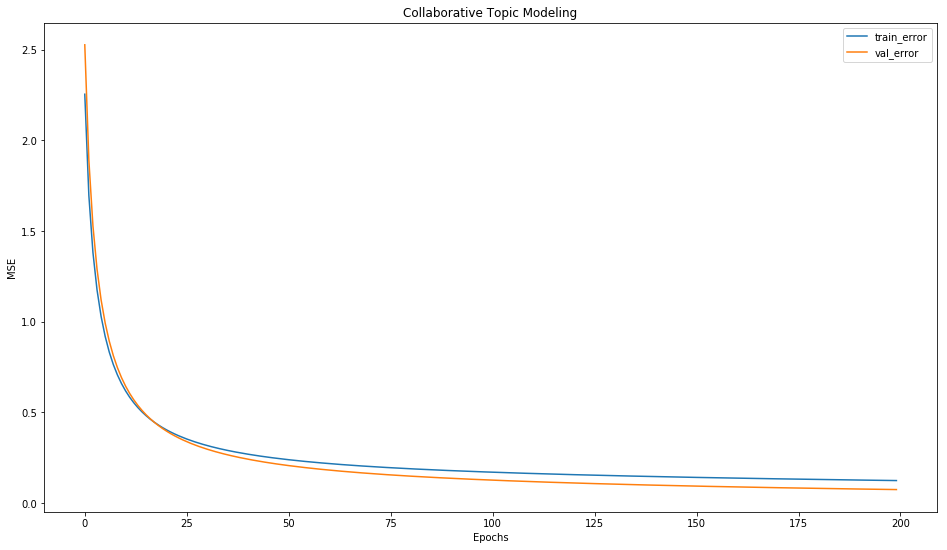

In [24]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(ctm.train_error, label = "train_error")
ax.plot(ctm.val_error, label = "val_error")
ax.set_title("Collaborative Topic Modeling")
ax.set_ylabel("MSE")
ax.set_xlabel("Epochs")
ax.legend();

In [25]:
# out-of-matrix prediction

heldout_predicted = np.dot(ctm.P.T, heldout_topics.values)

print(f"MSE for the heldout game - {heldout_name}:")
print(mse(heldout_predicted, heldout_ratings.values))

MSE for the heldout game - need for speed undercover:
0.29237484645396145


## Additional analyses
We can also study per-item topic relevances

In [26]:
gamename = "halflife"

# find the index number of halflife
for i, t in enumerate(R.columns):
    if t == gamename:
        idx = i
        break
        
print(f"Topic relevances for {gamename}:")        
for i, mixture in enumerate(ctm.Q[:, idx]):
    print(f"\t{round(mixture * 100, 2)}: {words_per_topic[i]}")

Topic relevances for halflife:
	28.71: ['new', 'player', 'world', 'level', 'can']
	0.37: ['vampire', 'rid', 'virus', 'slice', 'practice']
	0.37: ['ambient', 'logic', 'skull', 'pc', 'puzzle']
	0.37: ['mechanism', 'slave', 'drift', 'quad', 'penguin']
	0.84: ['fuel', 'roster', 'league', 'swap', 'bury']
	0.37: ['vassal', 'pour', 'dreamlike', 'manor', 'scour']
	0.37: ['wreck', 'writing', 'rig', 'dwell', 'deepen']
	5.59: ['zombie', 'car', 'soul', 'lie', 'final']
	0.37: ['minimal', 'subtle', 'dad', 'espionage', 'shower']
	2.83: ['subterranean', 'bubble', 'shark', 'vector', 'anomaly']
	0.37: ['shocking', 'offspring', 'commodity', 'smell', 'manic']
	0.37: ['orc', 'mercy', 'multipli', 'lively', 'manga']
	0.37: ['wizard', 'stick', 'humor', 'franchise', 'cell']
	0.37: ['restaurant', 'pedestrian', 'garbage', 'idle', 'd']
	0.37: ['heist', 'performer', 'overarch', 'catchy', 'diehard']


# Further investigation - which genres are most popular?

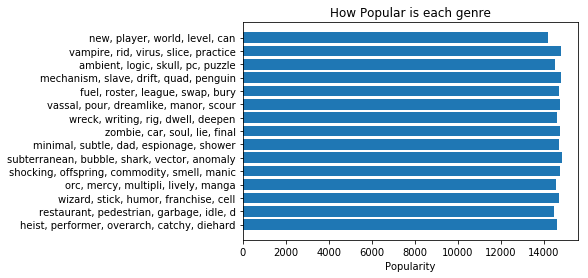

In [27]:
fig, ax = plt.subplots()

# Example data
labels = list(words_per_topic.values())
performance = ctm.P.sum(axis=1)

ax.barh([", ".join(l) for l in labels], performance, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Popularity')
ax.set_title('How Popular is each genre')

plt.show()

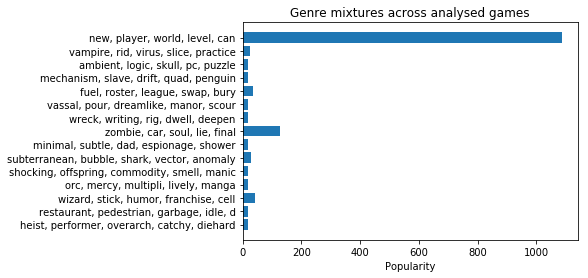

In [28]:
fig, ax = plt.subplots()

# Example data
labels = list(words_per_topic.values())
performance = ctm.Q.sum(axis=1)

ax.barh([", ".join(l) for l in labels], performance, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Popularity')
ax.set_title('Genre mixtures across analysed games')

plt.show()